In [1]:
from qiskit import QuantumCircuit, QuantumRegister, execute, Aer
from qiskit.extensions import UnitaryGate, SdgGate
from qiskit.visualization import plot_histogram
import numpy as np
from math import pi
# works with qiskit meta-package version 0.18.3
import warnings
warnings.filterwarnings("ignore") # suppress deprecation warnings

In [2]:
def createStatePreparationCircuit(qb,c):
    statePreparationCircuit=QuantumCircuit(qb)
    if c=="1":
        statePreparationCircuit.x(0) 
    elif c=="b0":
        statePreparationCircuit.ry(pi/4,0)
    elif c=="b1":
        statePreparationCircuit.rx(-pi/4,0)
        statePreparationCircuit.ry(-3*pi/2+pi/4,0)
        statePreparationCircuit.rz(pi/4,0)
    return statePreparationCircuit

In [3]:
def createCircuit(r,c,M):
    qa=QuantumRegister(1,name="a") #store ancilla
    qev=QuantumRegister(2,name="r") #store both eigenvalues
    qb=QuantumRegister(1,name="m") #store |b>
    qc=QuantumCircuit(qa,qev,qb)
    qc=qc+createStatePreparationCircuit(qb,c)
    qc.barrier();
    
    phaseEstimationCircuit=QuantumCircuit(qev,qb)
    phaseEstimationCircuit.h(qev[0])
    phaseEstimationCircuit.h(qev[1])
    # add Hamiltonian Simulation
    
    #e^{i A pi/2} with control qev[1] and target qb[0]
    hamiltonianOp=1/2*np.array([[complex(-1,1),complex(-1,-1)],
                   [complex(-1,-1),complex(-1,1)]])
    hamiltonianGate=UnitaryGate(hamiltonianOp)
    phaseEstimationCircuit.append(hamiltonianGate.control(1),[qev[1],qb[0]])
    # the controlled UnitaryGate can`t be inverted with qiskit meta-package version 0.19.2
    
    #e^{i pi A } with control qev[0] and target qb[0]
    phaseEstimationCircuit.cx(qev[0],qb[0]) #simply an X Gate 

    phaseEstimationCircuit.swap(qev[0],qev[1])
    phaseEstimationCircuit.h(qev[1])
    phaseEstimationCircuit.append(SdgGate().control(1),qev)
    phaseEstimationCircuit.h(qev[0])
    qc=qc+phaseEstimationCircuit
    
    qc.barrier();
    qc.swap(1,2)
    qc.cry(2*pi/2**r,1,0)
    qc.cry(pi/2**r,2,0);
    
    #invert circuit before Ry
    qc.swap(1,2)
    qc.barrier();
    # the following line produces problems with qiskit meta-package version 0.19.2:
    qc=qc+phaseEstimationCircuit.inverse()
    if M=="X":
        qc.h(qb[0]) 
    elif M=="Y":
        qc.sdg(qb[0]) 
        qc.h(qb[0]) 
    qc.measure_all()
    return qc

In [4]:
def measureExpectationValue(qc):
    counts=execute(qc,Aer.get_backend('qasm_simulator'),shots=20000).result().get_counts()
    if "0001" not in counts:
        a_square=0
    else:
        a_square=counts["0001"]
    if "1001" not in counts:
        b_square=0
    else:
        b_square=counts["1001"]
    # eigenvalues are 1 and -1
    expectationValue=(1*a_square+(-1)*b_square)/ (a_square+b_square)
    return expectationValue

{'0001': 158, '1000': 14600, '1001': 345, '0000': 4897}


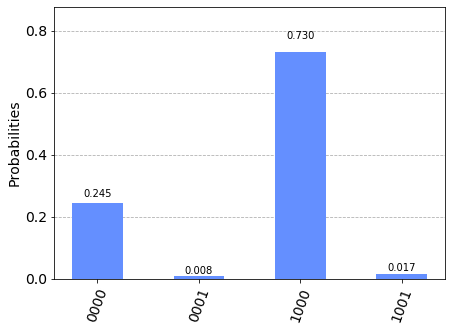

In [5]:
#setting parameter r as described in Figure 3 of the 2012 paper by Cao et al.:
r=4
qc=createCircuit(r,"b1","Z")
counts=execute(qc,Aer.get_backend('qasm_simulator'),shots=20000).result().get_counts()
print(counts)
plot_histogram(counts)

In [6]:
results={}
for M in ["X","Y","Z"]:
    for c in ["1","b0","b1"]:
        qc=createCircuit(r,c,M)
        results[(c,M)]=measureExpectationValue(qc)
        
for c,M in results.keys():
    M_X= results[(c,M)]
    print("Observing ",M," with input ",c," has expectation value ",'{:f}'.format(M_X.real)) # gives results as shown in the tables

Observing  X  with input  1  has expectation value  -0.572895
Observing  X  with input  b0  has expectation value  0.129151
Observing  X  with input  b1  has expectation value  -0.669941
Observing  Y  with input  1  has expectation value  -0.061983
Observing  Y  with input  b0  has expectation value  0.012346
Observing  Y  with input  b1  has expectation value  0.621181
Observing  Z  with input  1  has expectation value  -0.784615
Observing  Z  with input  b0  has expectation value  0.975309
Observing  Z  with input  b1  has expectation value  -0.376299
